IMX492, air, 584

broadband

In [1]:
# scoobpy.__file__

In [1]:
%matplotlib inline

import poppy
poppy.conf.use_cupy = False

import matplotlib.pyplot as plt
plt.rcParams.update({
    'image.origin' : 'lower',
    'image.interpolation' : 'nearest',
    'figure.dpi' : 100,
})
from matplotlib.colors import LogNorm, SymLogNorm

import numpy as np
from scoobpy import utils, iefc

from magpyx.utils import ImageStream
from magpyx.dm import control, dmutils
from magpyx import imutils, instrument

from purepyindi import INDIClient
from purepyindi import SwitchState as SwitchState0

from purepyindi2 import IndiClient, SwitchState #INDIClient
from time import sleep

from skimage.registration import phase_cross_correlation
from scipy.ndimage import center_of_mass

import deepdish as dd

from magpyx.instrument import set_camera_roi



/opt/conda/lib/python3.10/site-packages/cupyx/jit/_interface.py:173: FutureWarning: cupyx.jit.rawkernel is experimental. The interface can change in the future.
  cupy._util.experimental('cupyx.jit.rawkernel')


In [3]:
iefc.__file__

'/opt/MagAOX/source/cdeep_testbed_operations/scoobpy/scoobpy/iefc.py'

In [2]:
from importlib import reload
reload(iefc)
reload(control)

<module 'magpyx.dm.control' from '/opt/MagAOX/source/magpyx/magpyx/dm/control.py'>

In [15]:
import sys
sys.path.append('../')
from hcipy import *
import numpy as np
import kian_utils as kutils
# from utils import pad_or_crop

from matplotlib import pyplot as plt
from matplotlib import patches
from imshows import imshow1, imshow2, imshow3
import json
import scipy

# from magaox.camera import XCam
# from magaox.deformable_mirror import XDeformableMirror

import purepyindi2 as indi
import time
from magpyx.utils import ImageStream
# from efc_utils import *
from kvg_utils import ImageStream, CameraStream, move_relative


# Define DM mask (For rect Fourier probes function)
# Nact = 34
# dm_mask = np.ones((Nact,Nact), dtype=bool)
# xx = (np.linspace(-Nact/2, Nact/2-1, Nact)+ 1/2)
# x,y = np.meshgrid(xx,xx)
# r = np.sqrt(x**2 + y**2)
# dm_mask[r>Nact/2+1/2] = 0
# print(dm_mask.sum())
# imshow1(dm_mask)
# plt.savefig('josh_dm_mask.png')


# Setup

In [13]:
client0 = INDIClient('localhost', 7624)
client0.start()

client = IndiClient()
client.connect()
client.get_properties()

In [ ]:
# once the linear stage is homed, it's in the block_in position, so move it to block out

move_linear_preset(client0, 'block_out')

In [5]:
plate_scale = np.sqrt((87-78)**2 + (27-214)**2) / (30 * 2)
print(plate_scale)

3.120274204474842


In [6]:
dmch = ImageStream('dm00disp')
dmch1 = ImageStream('dm00disp01')
dmch3 = ImageStream('dm00disp03')
dmch4 = ImageStream('dm00disp04')
dmch5 = ImageStream('dm00disp05')
dmch6 = ImageStream('dm00disp06')

allch = [dmch, dmch1, dmch3, dmch4, dmch5, dmch6]
allchbutdh = [dmch, dmch3, dmch4, dmch5, dmch6]

dm_map, dm_mask = utils.get_kilo_map_mask()
#zterms = utils.get_kilo_zernikes()

In [34]:
set_camera_roi(client0, 'camsci', 4335, 3080, 200, 200, bin_x=2, bin_y=2)

In [19]:
#once you set the ROI, you need to intiate camstream 

In [11]:
camstream = CameraStream('camsci', client, 'camsci', 'fiberatten')

In [128]:
camstream.set_exposure_time(0.01, wait=1)
camstream.set_gain(0, wait=1)
camstream.set_attenuation(0, wait=0)

In [12]:
camstream.set_attenuation(0, wait=0)

NameError: name 'client' is not defined

In [130]:
iefc.zero_channels(allch)

# automated calibration


manually align to VVC

In [109]:
#move_relative(client, 'stagepiezo.stageqwp_pos', 50) # -34378L

In [42]:
move_relative(client, 'stagepiezo.stagepupil_x_pos', 5) # -34378L

In [43]:
move_relative(client, 'stagepiezo.stagepupil_y_pos', -2)

In [140]:

# TODO: Ask what the purpose of this step is?
# move_relative(client, 'stagepiezo.stagefold_pos', -50000) # + = in (left), - = out (right)

 automation starts here

In [141]:
#dmch3.write(dh_cmd_good)

In [142]:
#what does the small and large squares correspond to

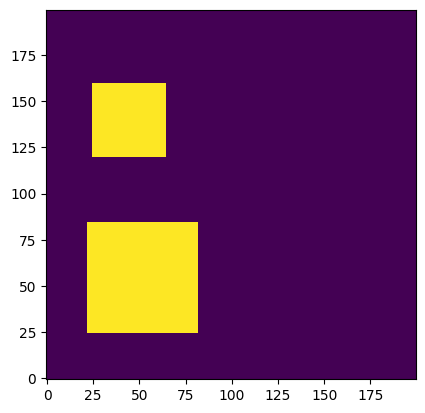

In [143]:
im_aligned = camstream.grab_latest()
shape = im_aligned.shape

mask = np.ones(shape, dtype=bool)
mask_speckle = np.zeros(shape, dtype=bool)
mask_speckle[140-20:140+20, 45-20:45+20] = 1
mask_core = np.zeros(shape, dtype=bool)
mask_core[45-20:45+40,42-20:42+40] = 1

calib_params = {
    'tilt_steps' : 60, # is this even used?
    'atten_max' : 10, #
    'atten_min' : 30,
    'gain_min' : 120,
    'gain_max' : 120,
    'cutout_extent_speckle' : 30,
    'cutout_extent_core' : 30,
    'mask_speckle' : mask_speckle,
    'mask_core' : mask_core,
    'plate_scale' : plate_scale,
    'exp_min' : 70e-4,
    'exp_max' : 1e-2,
    'exp_dh' : 1e-2,
}

plt.imshow(mask_speckle + mask_core)

In [144]:
iefc.zero_channels(allch)

In [153]:
camstream.set_exposure_time(0.1)

In [151]:
# TODO: Ask Ramya about this b/c this still confuses me a bit

# exp_min and gain_min should be set that off-axis core is not saturated but also such that
# at exp_max and gain_max you get high SNR on the speckle (without saturating once you max the source brightness)
#camstream.set_gain(120, wait=3)

# This is too bright for broadband
camstream.set_exposure_time(1e-2)

In [145]:
camstream.set_attenuation(20)

In [154]:
move_relative(client, 'stagepiezo.stagepupil_x_pos', -200) # -34378L

In [155]:
move_relative(client, 'stagepiezo.stagepupil_y_pos', -200) # -34378L

In [146]:
%%time
im_core, im_speckle, im_dh, im_core_bg, im_speckle_bg, im_dh_bg = autocalibrate_pre(im_aligned, camstream, client,
                                               calib_params, skip_fsm=False,
                                               manual_intervention=False,
                                               realign=False)

Driving PSF off-axis
Adjusting for non-saturated core


INFO:utils:Got semaphore index 1.


Taking measurements at settings for non-saturated core


KeyboardInterrupt: 

(slice(132, 162, None), slice(24, 54, None)) (slice(35, 65, None), slice(28, 58, None))
Attenuation factor: 0.9654042962947244
Core CPS: 2530504508.8054066
Speckle contrast: 0.0006058396770020933
Core contrast: 1.0
3.9517811429313643e-10


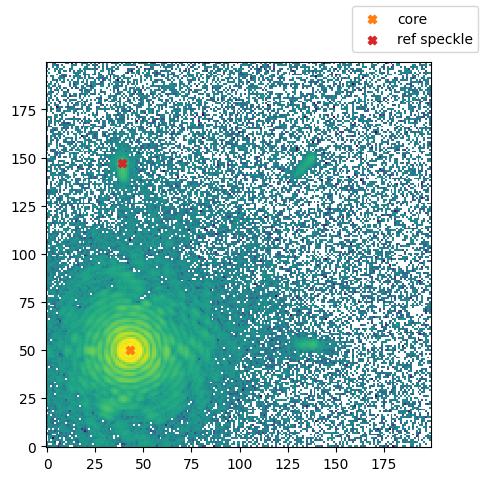

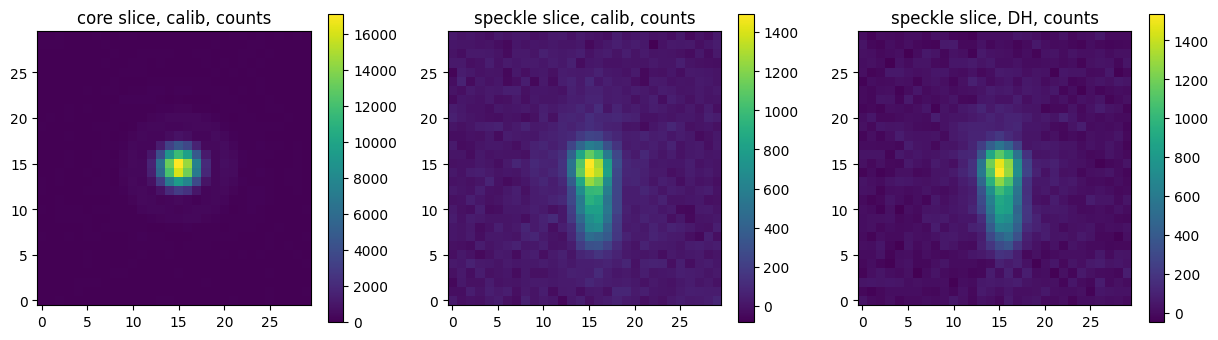

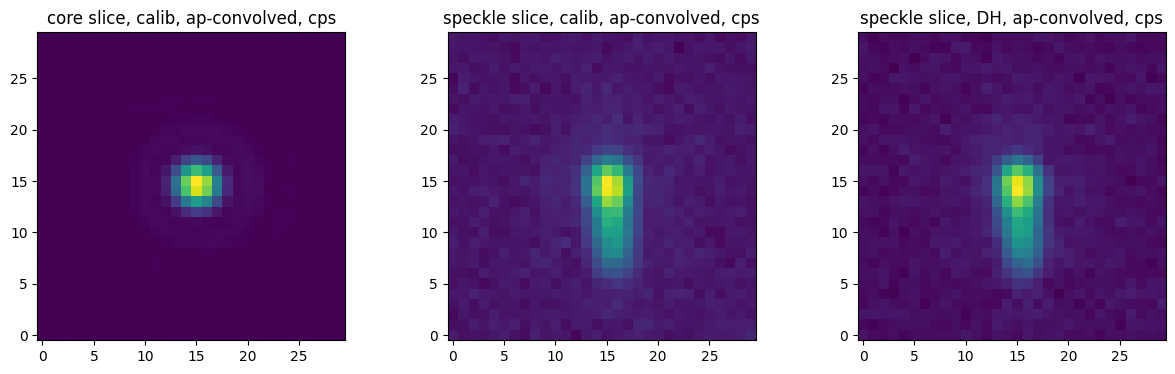

In [87]:
calib_proc = process_calibration_measurements(im_core-im_core_bg, im_speckle-im_speckle_bg, im_dh-im_dh_bg,
                                              calib_params, skip_conv=True)

display_calibration(calib_proc, im_core-im_core_bg, im_speckle-im_speckle_bg, im_dh-im_dh_bg)

norm_cps = calib_proc['core_cps_dh']
print(1/norm_cps)

In [99]:
camstream.set_exposure_time(0.0001)

In [89]:
camstream.set_gain(120)

In [90]:
imbg = take_bg()

In [91]:
print(np.mean(imbg)/norm_cps)

0.02307436836088261


save all the things!

In [92]:
basedir = 'iefc_2024_09_03_Broadband_IMX294_BeamCoSubstrateVVC_aeroglazeLS_584_jl_test'

In [93]:
import os
#os.mkdir(basedir)

In [94]:
allcalib = {
    'calib_params' : calib_params,
    'calib_proc' : calib_proc,
    'im_core' : im_core,
    'im_speckle' : im_speckle,
    'im_dh' : im_dh,
    'im_core_bg' : im_core_bg,
    'im_speckle_bg' : im_speckle_bg,
    'im_dh_bg' : im_dh_bg,
    #'im_bg' : imbg,
}

In [95]:
#save_dict_to_h5(os.path.join(basedir, 'allcalib.h5'), allcalib)

reset alignment

In [101]:
move_relative(client, 'stagepiezo.stagepupil_x_pos', 2) # -34378L

In [105]:
move_relative(client, 'stagepiezo.stagepupil_y_pos', -1) # -34378L

### off-axis throughput measurement

* Slowly walk PSF off-axis (2-15 lambda/D-ish) and measure core (can't be saturated)

# DH 1

calibration parameters

In [144]:
atten = 0
camstream.set_attenuation(atten, wait=5)
camstream.set_exposure_time(5e-3, wait=5)
t1 = camstream.get_exposure_time() * 10**(-atten/10)

In [145]:
print(f'Contrast limit at this exposure time ~ {2/1e-3/norm_cps}')

Contrast limit at this exposure time ~ 7.826357146250892e-07


In [54]:
iefc.zero_channels(allch)

calibrate

In [55]:
imbg = take_bg()

In [ ]:
# From Kian Milani...
def create_fourier_modes(control_mask,
                         fourier_sampling=0.75, use='both', return_fs=False):
    xfp = (np.linspace(-npsf/2, npsf/2-1, npsf) + 1/2) * psf_pixelscale_lamD
    fpx, fpy = np.meshgrid(xfp,xfp)
    
    intp = scipy.interpolate.interp2d(xfp, xfp, control_mask) # setup the interpolation function
    
    xpp = np.linspace(-Nact/2, Nact/2-1, Nact) + 1/2
    ppx, ppy = np.meshgrid(xpp,xpp)
    
    fourier_lim = fourier_sampling * int(np.round(xfp.max()/fourier_sampling))
    xfourier = np.arange(-fourier_lim-fourier_sampling/2, fourier_lim+fourier_sampling, fourier_sampling)
    fourier_x, fourier_y = np.meshgrid(xfourier, xfourier) 
    
    # Select the x,y frequencies for the Fourier modes to calibrate the dark hole region
    fourier_grid_mask = ( (intp(xfourier, xfourier) * (((fourier_x!=0) + (fourier_y!=0)) > 0)) > 0 )
    
    fxs = fourier_x.ravel()[fourier_grid_mask.ravel()]
    fys = fourier_y.ravel()[fourier_grid_mask.ravel()]
    sampled_fs = np.vstack((fxs, fys)).T
    
    cos_modes = []
    sin_modes = []
    for f in sampled_fs:
        fx = f[0]/Nact
        fy = f[1]/Nact
        cos_modes.append( ( np.cos(2 * np.pi * (fx * ppx + fy * ppy)) * dm_mask ).flatten() ) 
        sin_modes.append( ( np.sin(2 * np.pi * (fx * ppx + fy * ppy)) * dm_mask ).flatten() )
    if use=='both' or use=='b':
        modes = cos_modes + sin_modes
    elif use=='cos' or use=='c':
        modes = cos_modes
    elif use=='sin' or use=='s':
        modes = sin_modes
    
    if return_fs:
        return np.array(modes), sampled_fs
    else:
        return np.array(modes)

def fourier_mode(lambdaD_yx, rms=1, acts_per_D_yx=(34,34), Nact=34, phase=0):
    idy, idx = np.indices((Nact, Nact)) - (34-1)/2.
    prefactor = rms * np.sqrt(2)
    arg = 2*np.pi*(lambdaD_yx[0]/acts_per_D_yx[0]*idy + lambdaD_yx[1]/acts_per_D_yx[1]*idx)
    return prefactor * np.cos(arg + phase)

def create_fourier_probes(control_mask,
                          fourier_sampling=0.25, 
                          shift=(0,0), 
                          nprobes=2, 
                          use_weighting=False,
                          plot=False, 
                          calc_responses=False): 
#     make probe modes from the sum of the cos and sin fourier modes
    fourier_modes, fs = create_fourier_modes(control_mask, fourier_sampling=fourier_sampling, use='both', return_fs=True)
    nfs = fourier_modes.shape[0]//2
    
    probes = np.zeros((nprobes, Nact, Nact))
    if use_weighting:
        fmax = np.max(np.sqrt(fs[:,0]**2 + fs[:,1]**2))
        sum_cos = 0.0
        sum_sin = 0.0
        for i in range(nfs):
            f = np.sqrt(fs[i][0]**2 + fs[i][1]**2)
            weight = f/fmax
            sum_cos += weight * fourier_modes[i]
            sum_sin += weight * fourier_modes[i+nfs]
        sum_cos = sum_cos.reshape(Nact,Nact)
        sum_sin = sum_sin.reshape(Nact,Nact)
    else:
        sum_cos = fourier_modes[:nfs].sum(axis=0).reshape(Nact,Nact)
        sum_sin = fourier_modes[nfs:].sum(axis=0).reshape(Nact,Nact)
    
    # nprobes=2 will give one probe that is purely the sum of cos and another that is the sum of sin
    cos_weights = np.linspace(1,0,nprobes)
    sin_weights = np.linspace(0,1,nprobes)
    
    if not isinstance(shift, list):
        shifts = [shift]*nprobes
    else:
        shifts = shift
    for i in range(nprobes):
        probe = cos_weights[i]*sum_cos + sin_weights[i]*sum_sin
        probe = scipy.ndimage.shift(probe, (shifts[i][1], shifts[i][0]))
        probes[i] = probe/np.max(probe)
        
        if plot: 
            response = np.abs(np.fft.ifftshift(np.fft.fft2(np.fft.fftshift( kutils.pad_or_crop(probes[i], 4*Nact) ))))
            imshow2(probes[i], response, pxscl2=1/4)

       
    return probes

In [1]:
npsf = 256 # TODO: Check this w/ Kian


# Define pixel grid for control mask
x = (np.linspace(-npsf//2, npsf//2 -1, npsf,) + 1/2) * psf_pixelscale_lamD
x,y = np.meshgrid(x,x)

# Controllable fourier modes
iwa = 1
owa = 11
width = 28

control_mask = np.ones((npsf,npsf), dtype=bool)
control_mask *= (x<width//2)*(x>-width//2) * (y<-iwa) * (y>-owa)
# control_mask[x>-width//2]=1
imshow1(control_mask)

# Define Fourier probes (essentially sinc functions)
probe_modes = create_fourier_probes(control_mask, 
                                    shift=[(-6,0), (6,0)],
                                    use_weighting=True,
                                    plot=True)

NameError: name 'np' is not defined

In [146]:
%%time
#iefc.zero_channels(allchbutdh)

hval = 0.002
pval = 0.002
num = 3
alpha = 2#0
fmin = 2
fmax = 16
navg = 1
dmdelay = 4

im_slice = (slice(None), slice(None))
region_slice = (slice(None), slice(None), slice(None), slice(None))
weight = np.ones_like(imbg)

# TODO: Replace get_random_probes, get_combined_response_matrix with custom sinc probe function, Jacobian of Fourier modes

# Make sure return args are the same as get_combined_response_matrix

probes1 = iefc.get_random_probes(pval, alpha, dm_mask, fmask=None, fmin=fmin, fmax=fmax, nprobe=num)#fmask


# Replace hmodes w/ Fourier modes

# TODO: Investigate outputs respM1, hmodes, hcmds--see if I can replace these

respM1, respM_combined, hmodes, hcmds = iefc.get_combined_response_matrix(camstream, dmch4, dmch5, probes1,
                                                                         hval, weight, region_slice,
                                                                         im_slice, navg=navg, dmdelay=dmdelay,
                                                                         nrepeat=1, gauss_sigma=None)

50/1024
100/1024
150/1024
200/1024
250/1024
300/1024
350/1024
400/1024
450/1024
500/1024
550/1024
600/1024
650/1024
700/1024
750/1024
800/1024
850/1024
900/1024
950/1024
1000/1024
CPU times: user 1min 15s, sys: 44.5 s, total: 1min 59s
Wall time: 5min 11s


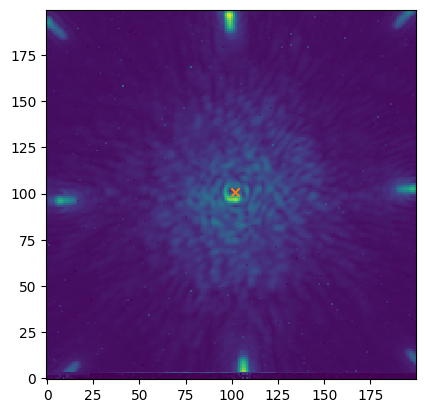

In [147]:
coreyx = (101, 101.5)
plt.imshow(np.sqrt(np.mean(respM1**2, axis=(0,1))))
plt.scatter(coreyx[1], coreyx[0], marker='x', c='C1')

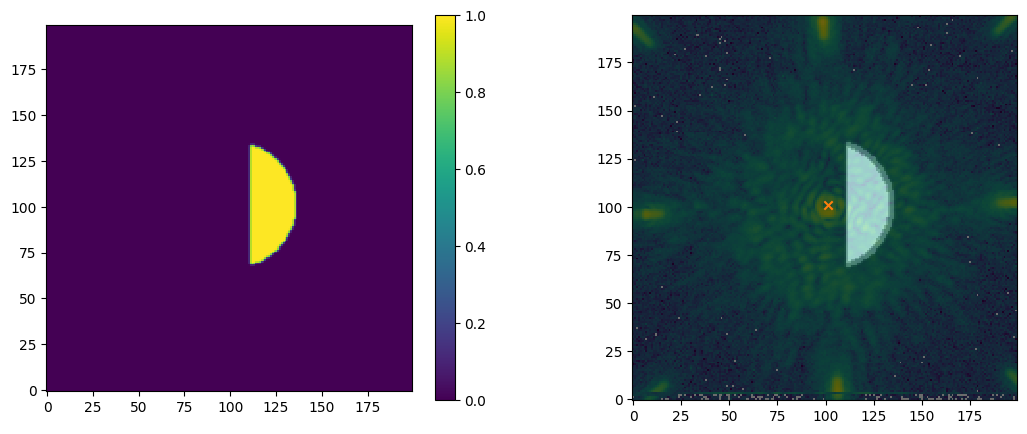

In [148]:
# choose wfs window
im = np.mean(camstream.grab_many(10),axis=0)

ceny, cenx = coreyx
angle = 0

# larger DH
iwa_lambdaD = 2.5
owa_lambdaD = 11

dh_mask = get_semicircular_mask(ceny, cenx, iwa_lambdaD, owa_lambdaD, plate_scale, im.shape, angle, iwa_margin=1.105)
weighting0 = imutils.gauss_convolve(dh_mask.astype(float), 0.5)


# smaller DH
iwa_lambdaD = 2.7
owa_lambdaD = 10.3#
dh_mask = get_semicircular_mask(ceny, cenx, iwa_lambdaD, owa_lambdaD, plate_scale, im.shape, angle, iwa_margin=1.105)
mask_dh = dh_mask

#dh_mask = get_circular_mask(ceny, cenx, 0, 20, plate_scale, im.shape)
#mask_dh = dh_mask


# DH mask proper
iwa_lambdaD = 3
owa_lambdaD = 10#
dh_mask_proper = get_semicircular_mask(ceny, cenx, iwa_lambdaD, owa_lambdaD, plate_scale, im.shape, angle, iwa_margin=1.105)
mask_dh_proper = dh_mask_proper


fig, axes = plt.subplots(1,2,figsize=(13,5))
pim = axes[0].imshow(weighting0[im_slice])
fig.colorbar(pim, ax=axes[0])

axes[1].imshow(np.sqrt(im), norm=LogNorm())
axes[1].imshow(mask_dh, alpha=0.25, cmap='Greys_r')
axes[1].imshow(mask_dh_proper, alpha=0.25, cmap='Greys_r')
axes[1].scatter(coreyx[1], coreyx[0], marker='x', c='C1')
axes[1].imshow(weighting0, alpha=0.25, cmap='Greys_r')

In [101]:
save_dict_to_h5(os.path.join(basedir, 'dh_mask_proper.h5'), dh_mask_proper)

In [149]:
imdh = np.mean(camstream.grab_many(10),axis=0) #/ t1
contrast_dh = np.mean((imdh-imbg)[mask_dh_proper]) / norm_cps
print(contrast_dh)
print(get_mean_contrast(imdh, imbg, mask_dh_proper, norm_cps, rejectnegative=True))

6.985002572304352e-06
7.102570942565624e-06


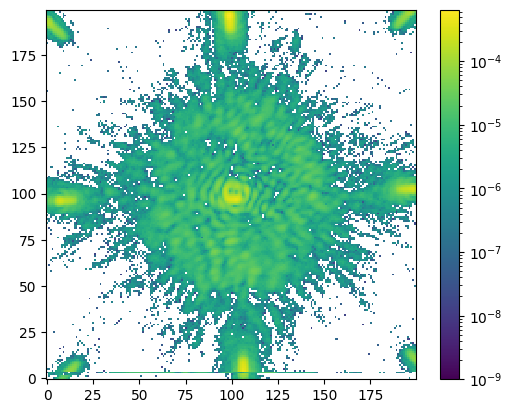

In [150]:
plt.imshow((imdh-imbg)/norm_cps, norm=LogNorm(vmin=1e-9))
plt.colorbar()

In [151]:
run_settings_1 = {
    'atten' : 0,
    'exptime' : 5e-3,
    'navg' : 4,
    'mask' : weighting0,
    'reg' : 1e-2,
    'scale' : 1.,
    'leak' : 0.1,
    'niter' : 15,
    'dobg' : True,
}

run_settings_2 = {
    'atten' : 0,
    'exptime' : 1e-2,
    'navg' : 4,
    'mask' : dh_mask,
    'reg' : 1e-2,
    'scale' : 1,
    'leak' : 0.0,
    'niter' : 15,
    'dobg' : True,
}


run_settings_3 = {
    'atten' : 0,
    'exptime' : 1e-2,
    'navg' : 4,
    'mask' : 'residual',
    'reg' : 1e-2,
    'scale' : 2,
    'leak' : 0.0,
    'niter' : 10,
    'dobg' : False,

}

run_settings_4 = {
    'atten' : 0,
    'exptime' : 1e-2,
    'navg' : 4,
    'mask' : dh_mask,
    'reg' : 1e-2,
    'scale' : 2,
    'leak' : 0.0,
    'niter' : 15,
    'dobg' : False,
}


In [152]:
sequence = [run_settings_1,run_settings_2,run_settings_3,run_settings_4]

In [153]:
iefc.zero_channels(allch)

In [154]:
allseq_data = {}
for i, seq in enumerate(sequence):
    
    print('Setting camera')
    camstream.set_attenuation(seq['atten'], wait=5)
    camstream.set_exposure_time(seq['exptime'], wait=5)
    
    if seq['dobg']:
        print('Taking background')
        imbg = take_bg(n=100, nwait=10)
        #imbg = take_bg_atten(n=100, nwait=10)

    print('Recomputing control matrix')
    weight = seq['mask']
    if isinstance(weight, str):
        weight = dh_mask * imutils.gauss_convolve(( np.mean(camstream.grab_many(10),axis=0) - imbg )*dh_mask, 1)#**(0.5)
    respM_combined = np.concatenate([respM1[region_slice][:,n]*weight[im_slice] for n in range(num)],
                                axis=-1)
    ctrldict = control.get_control_matrix_from_hadamard_measurements(respM_combined, hmodes, hval, dm_map,
                                                                 dm_mask, wfsthresh=0.25,
                                                                 regtype='hybrid', treg=seq['reg'],
                                                                 dmthresh=0.01, ninterp=3, nmodes=950, #950
                                                                 deltas=True, svd_if=True)
    #iefc.display_control_matrix(ctrldict)
    
    
    print('Running iEFC')
    filter_params = {
    'fmin' : 15,
    'fmax' : 50,
    'dm_weight' : 1 - ctrldict['dmmap'] / ctrldict['dmmap'].max()
    }
    probe_imlist = []
    dh_imlist = []
    tstamp_imlist = []
    scale = seq['scale']
    leak = seq['leak']
    niter = seq['niter']
    navg = seq['navg']
    allcmds, allresid, dh_cmd = iefc.run_iefc_cl(camstream, dmch5, dmch3, probes1, im_slice,
                                                 weight, ctrldict, dm_map, dm_mask,
                                                 niter=niter, gain=0.5*scale, leak=leak, filter_leak=True, filter_params=filter_params,
                                                 scale=1*scale, delay=0.3,
                                                 probe_imlist=probe_imlist, dh_imlist=dh_imlist,tstamp_imlist=tstamp_imlist,
                                                 threshold=None, navg=navg,
                                                 dmdelay=5, bg=imbg, norm_cps=norm_cps,
                                                 nrepeat=1, reg=None)
    
    print('Consolidating data products')
    seq_dict = {
        'dh_imlist' : dh_imlist,
        'tstamp_imlist' : tstamp_imlist,
        'probe_imlist' : probe_imlist,
        'allcmds' : allcmds,
        'allresid' : allresid,
        'dh_cmd' : dh_cmd,
        'imbg' : imbg,
        'run_settings' : seq,
    }
    allseq_data[i] = seq_dict

Setting camera
Taking background
Recomputing control matrix


INFO:control:Iteration: 1/15


Running iEFC
mean contrast: 8.528258737689187e-06


INFO:control:Iteration: 2/15


mean contrast: 3.953033420116183e-06


INFO:control:Iteration: 3/15


mean contrast: 2.052246368478047e-06


INFO:control:Iteration: 4/15


mean contrast: 1.2395686548936176e-06


INFO:control:Iteration: 5/15


mean contrast: 8.205251283692574e-07


INFO:control:Iteration: 6/15


mean contrast: 6.550836556694389e-07


INFO:control:Iteration: 7/15


mean contrast: 5.104890719776161e-07


INFO:control:Iteration: 8/15


mean contrast: 4.43947486861185e-07


INFO:control:Iteration: 9/15


mean contrast: 4.0920267184785874e-07


INFO:control:Iteration: 10/15


mean contrast: 3.6898291628697784e-07


INFO:control:Iteration: 11/15


mean contrast: 3.325535041820963e-07


INFO:control:Iteration: 12/15


mean contrast: 3.1332102072017425e-07


INFO:control:Iteration: 13/15


mean contrast: 2.875607235284757e-07


INFO:control:Iteration: 14/15


mean contrast: 2.904385768932159e-07


INFO:control:Iteration: 15/15


mean contrast: 2.7162724270418254e-07
Consolidating data products
Setting camera
Taking background
Recomputing control matrix


INFO:control:Iteration: 1/15


Running iEFC
mean contrast: 2.1629246382793683e-07


INFO:control:Iteration: 2/15


mean contrast: 1.8999321734826836e-07


INFO:control:Iteration: 3/15


mean contrast: 1.7447479673047818e-07


INFO:control:Iteration: 4/15


mean contrast: 1.6123191375135433e-07


INFO:control:Iteration: 5/15


mean contrast: 1.6029931635845826e-07


INFO:control:Iteration: 6/15


mean contrast: 1.5160750865666714e-07


INFO:control:Iteration: 7/15


mean contrast: 1.469445216921869e-07


INFO:control:Iteration: 8/15


mean contrast: 1.3306747248589378e-07


INFO:control:Iteration: 9/15


mean contrast: 1.3940913475758686e-07


INFO:control:Iteration: 10/15


mean contrast: 1.401552126719037e-07


INFO:control:Iteration: 11/15


mean contrast: 1.372082049103522e-07


INFO:control:Iteration: 12/15


mean contrast: 1.3127688549153335e-07


INFO:control:Iteration: 13/15


mean contrast: 1.364248231003195e-07


INFO:control:Iteration: 14/15


mean contrast: 1.2769571150281254e-07


INFO:control:Iteration: 15/15


mean contrast: 1.332912958601888e-07
Consolidating data products
Setting camera
Recomputing control matrix


INFO:control:Iteration: 1/10


Running iEFC
mean contrast: 1.448482982076302e-07


INFO:control:Iteration: 2/10


mean contrast: 1.3440527358470142e-07


INFO:control:Iteration: 3/10


mean contrast: 1.3007043317518379e-07


INFO:control:Iteration: 4/10


mean contrast: 1.289276116126746e-07


INFO:control:Iteration: 5/10


mean contrast: 1.3334126730236526e-07


INFO:control:Iteration: 6/10


mean contrast: 1.3018865609544338e-07


INFO:control:Iteration: 7/10


mean contrast: 1.3007043317518379e-07


INFO:control:Iteration: 8/10


mean contrast: 1.534785713865789e-07


INFO:control:Iteration: 9/10


mean contrast: 1.4004056611707432e-07


INFO:control:Iteration: 10/10


mean contrast: 1.4666104965161028e-07
Consolidating data products
Setting camera
Recomputing control matrix


INFO:control:Iteration: 1/15


Running iEFC
mean contrast: 1.4474359184495225e-07


INFO:control:Iteration: 2/15


mean contrast: 1.3041889589006898e-07


INFO:control:Iteration: 3/15


mean contrast: 1.4198310356197995e-07


INFO:control:Iteration: 4/15


mean contrast: 1.4086398669050469e-07


INFO:control:Iteration: 5/15


mean contrast: 1.3676055816176212e-07


INFO:control:Iteration: 6/15


mean contrast: 1.4146084902195814e-07


INFO:control:Iteration: 7/15


mean contrast: 1.3224678678014527e-07


INFO:control:Iteration: 8/15


mean contrast: 1.3937183086187104e-07


INFO:control:Iteration: 9/15


mean contrast: 1.3164992444869178e-07


INFO:control:Iteration: 10/15


mean contrast: 1.307546309515116e-07


INFO:control:Iteration: 11/15


mean contrast: 1.4008060488047202e-07


INFO:control:Iteration: 12/15


mean contrast: 1.3269443352873535e-07


INFO:control:Iteration: 13/15


mean contrast: 1.360517841431611e-07


INFO:control:Iteration: 14/15


mean contrast: 1.4340065159918195e-07


INFO:control:Iteration: 15/15


mean contrast: 1.3493266727168584e-07
Consolidating data products


save out data products

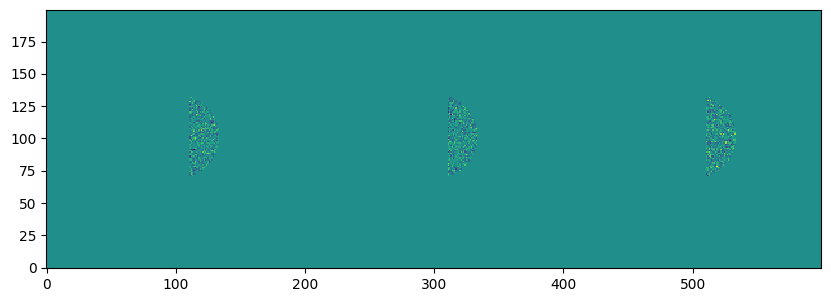

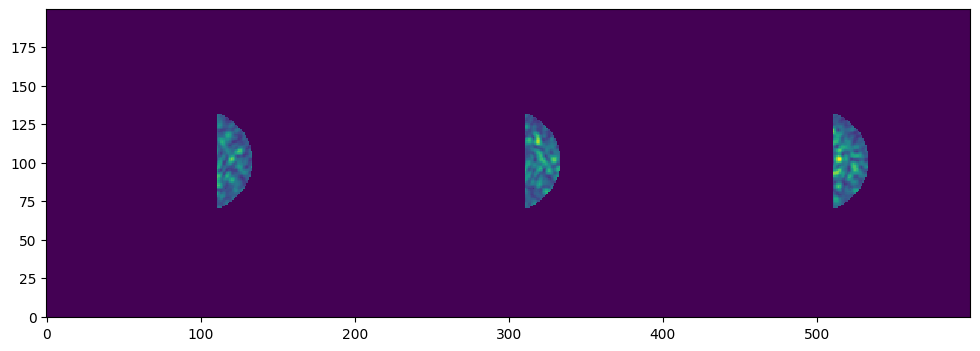

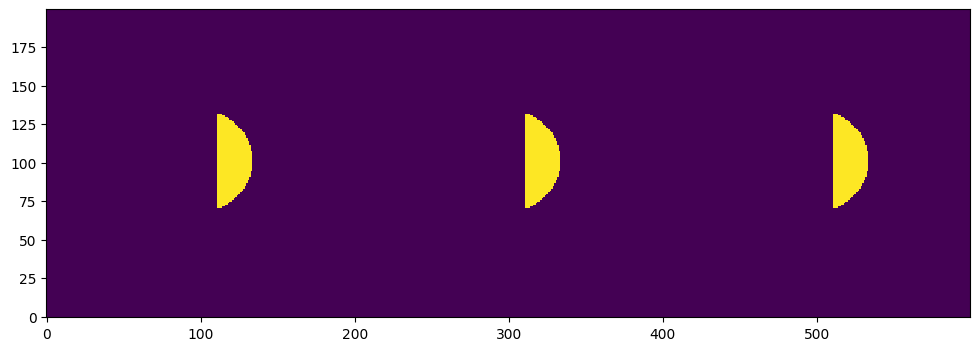

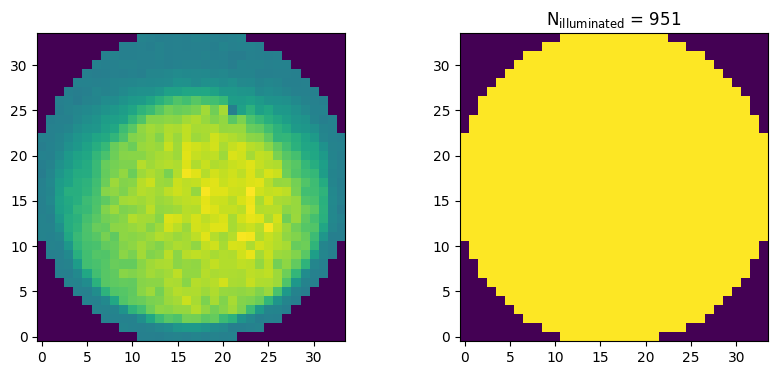

In [155]:
iefc.display_control_matrix(ctrldict)

In [468]:
save_dict_to_h5(os.path.join(basedir, 'calib1_seq.h5'), allseq_data)
#save_dict_to_h5(os.path.join(basedir, 'calib1_seq_fieldstop.h5'), allseq_data)

In [66]:
dh_cmd_good = dh_cmd

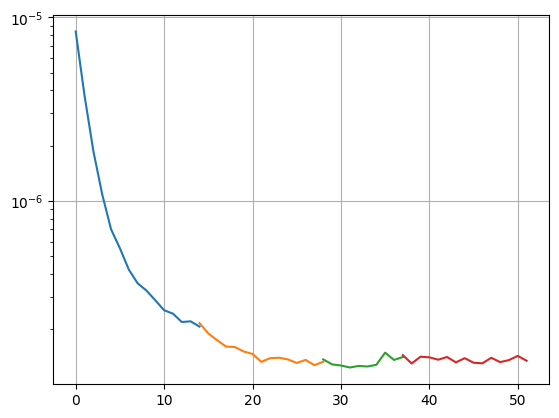

In [156]:
iter0 = np.asarray(list(range(allseq_data[0]['run_settings']['niter'])))
iter1 = np.asarray(list(range(allseq_data[1]['run_settings']['niter']))) + iter0[-1]
iter2 = np.asarray(list(range(allseq_data[2]['run_settings']['niter']))) + iter1[-1]
iter3 = np.asarray(list(range(allseq_data[3]['run_settings']['niter']))) + iter2[-1]

plt.semilogy(iter0, np.mean((np.asarray(allseq_data[0]['dh_imlist']) - allseq_data[0]['imbg'])[:,dh_mask], axis=-1)/norm_cps)
plt.semilogy(iter1, np.mean((np.asarray(allseq_data[1]['dh_imlist']) - allseq_data[1]['imbg'])[:,dh_mask], axis=-1)/norm_cps)
plt.semilogy(iter2, np.mean((np.asarray(allseq_data[2]['dh_imlist']) - allseq_data[2]['imbg'])[:,dh_mask], axis=-1)/norm_cps)
plt.semilogy(iter3, np.mean((np.asarray(allseq_data[3]['dh_imlist']) - allseq_data[3]['imbg'])[:,dh_mask], axis=-1)/norm_cps)

plt.grid()

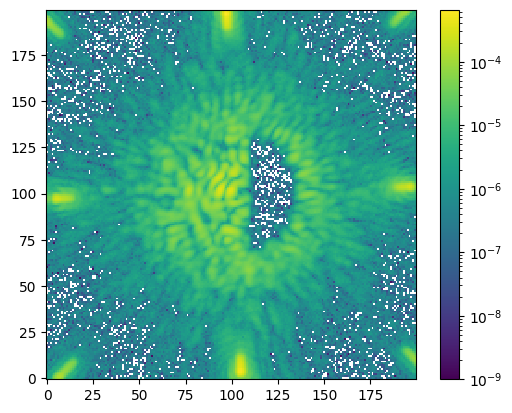

In [68]:
plt.imshow( (allseq_data[3]['dh_imlist'][-1] - allseq_data[3]['imbg'])/norm_cps, norm=LogNorm(vmin=1e-9))
plt.colorbar()

 deeper DH measurements

In [69]:
print('Setting camera')
#camstream.set_attenuation(0, wait=1)
camstream.set_exposure_time(0.05, wait=5)

imdh = np.mean(camstream.grab_many(100),axis=0) #/ t1

print('Taking background')
imbg = take_bg(n=100, nwait=10)

Setting camera
Taking background


In [70]:
contrast_dh = np.mean((imdh-imbg)[dh_mask])/ norm_cps
print(contrast_dh)
print(get_mean_contrast(imdh, imbg, dh_mask, norm_cps))

2.755485795126892e-07
2.758134622286696e-07


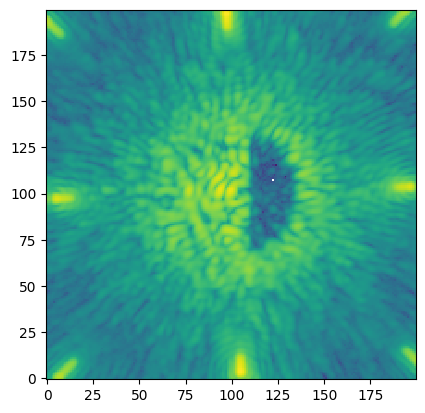

In [71]:
plt.imshow((imdh-imbg)/norm_cps, norm=LogNorm(vmin=1e-9))

In [72]:
dh_ims = {
    'imdh' : imdh,
    'imbg' : imbg,
    'mask' : dh_mask
}

#save_dict_to_h5(os.path.join(basedir, 'calib1_dh.h5'), dh_ims)

# DH 2

calibration parameters

In [73]:
atten = 0
#camstream.set_attenuation(atten, wait=1)
camstream.set_exposure_time(10e-3, wait=5)
t2 = camstream.get_exposure_time() * 10**(-atten/10)

In [74]:
imdh = np.mean(camstream.grab_many(10),axis=0) #/ t1
contrast_dh = np.mean((imdh-imbg)[mask_dh]) / norm_cps
print(contrast_dh)
print(get_mean_contrast(imdh, imbg, mask_dh, norm_cps, rejectnegative=True))

3.1221895308298243e-07
3.287209666583032e-07


In [75]:
dmch3.write(dh_cmd_good)

In [279]:
iefc.get_random_probes??

In [76]:
%%time
#iefc.zero_channels(allchbutdh)

hval = 0.0005
pval = 0.0005
num = 3
alpha = 2
fmin = 2
fmax = 14
navg = 1
dmdelay = 4 
weight = weighting0

probes2 = iefc.get_random_probes(pval, alpha, dm_mask, fmask=None, fmin=fmin, fmax=fmax, nprobe=num)#fmask

respM2, respM_combined, hmodes, hcmds = iefc.get_combined_response_matrix(camstream, dmch4, dmch5, probes2,
                                                                         hval, weight, region_slice,
                                                                         im_slice, navg=navg, dmdelay=dmdelay,
                                                                         nrepeat=1, gauss_sigma=None)

50/1024
100/1024
150/1024
200/1024
250/1024
300/1024
350/1024
400/1024
450/1024
500/1024
550/1024
600/1024
650/1024
700/1024
750/1024
800/1024
850/1024
900/1024
950/1024
1000/1024
CPU times: user 10 s, sys: 1.21 s, total: 11.2 s
Wall time: 8min 21s


In [77]:
run_settings_1 = {
    'atten' : 0,
    'exptime' : 50e-2,
    'mask' : dh_mask,
    'reg' : 1e-2,
    'scale' : 1.0,
    'leak' : 0.,
    'niter' : 15,
    'dobg' : True,
}

run_settings_2 = {
    'atten' : 0,
    'exptime' : 50e-2,
    'mask' : dh_mask,
    'reg' : 1e-9,
    'scale' : 1.0,
    'leak' : 0.,
    'niter' : 7,
    'dobg' : False,
}

run_settings_3 = {
    'atten' : 0,
    'exptime' : 50e-2,
    'mask' : dh_mask,
    'reg' : 1e-2,
    'scale' : 1.0,
    'leak' : 0.,
    'niter' : 10,
    'dobg' : False,
}

run_settings_4 = {
    'atten' : 0,
    'exptime' : 50e-2,
    'mask' : 'residual',
    'reg' : 1e-3,
    'scale' : 1.0,
    'leak' : 0.,
    'niter' : 7,
    'dobg' : True,
}

run_settings_5 = {
    'atten' : 0,
    'exptime' : 50e-2,
    'mask' : dh_mask,
    'reg' : 1e-1,
    'scale' : 1.0,
    'leak' : 0.,
    'niter' : 10,
    'dobg' : False,
}

run_settings_6 = {
    'atten' : 0,
    'exptime' : 50e-2,
    'mask' : dh_mask,
    'reg' : 1e-2,
    'scale' : 1.0,
    'leak' : 0.,
    'niter' : 10,
    'dobg' : False,
}


# a sequence should assume a common calibration
sequence = [run_settings_1, run_settings_2, run_settings_3,
            run_settings_4, run_settings_5, run_settings_6]

In [85]:
#sequence = [run_settings_4, run_settings_5, run_settings_6,]

In [78]:
#allseq_data = {}
for i, seq in enumerate(sequence):
    
    print('Setting camera')
    camstream.set_attenuation(seq['atten'], wait=5)
    camstream.set_exposure_time(seq['exptime'], wait=5)
    
    if seq['dobg']:
        print('Taking background')
        imbg = take_bg(n=100, nwait=10)
    
    print('Recomputing control matrix')
    weight = seq['mask']
    if isinstance(weight, str):
        weight = dh_mask * imutils.gauss_convolve(( np.mean(camstream.grab_many(10),axis=0) - imbg )*dh_mask, 1)#**(0.5)
    respM_combined = np.concatenate([respM2[region_slice][:,n]*weight[im_slice] for n in range(num)],
                                axis=-1)
    ctrldict = control.get_control_matrix_from_hadamard_measurements(respM_combined, hmodes, hval, dm_map,
                                                                 dm_mask, wfsthresh=0.25,
                                                                 regtype='hybrid', treg=seq['reg'],
                                                                 dmthresh=0.01, ninterp=3, nmodes=951,
                                                                 deltas=True, svd_if=True)
    #iefc.display_control_matrix(ctrldict)
    
    
    print('Running iEFC')
    filter_params = {
    'fmin' : 15,
    'fmax' : 50,
    'dm_weight' : 1 - ctrldict['dmmap'] / ctrldict['dmmap'].max()
    }
    probe_imlist = []
    dh_imlist = []
    tstamp_imlist = []
    scale = seq['scale']
    leak = seq['leak']
    niter = seq['niter']
    allcmds, allresid, dh_cmd = iefc.run_iefc_cl(camstream, dmch5, dmch3, probes2, im_slice,
                                                 weight, ctrldict, dm_map, dm_mask,
                                                 niter=niter, gain=0.5*scale, leak=leak, filter_leak=True, filter_params=filter_params,
                                                 scale=1*scale, delay=0.3,
                                                 probe_imlist=probe_imlist, dh_imlist=dh_imlist, tstamp_imlist=tstamp_imlist,
                                                 threshold=None, navg=4,
                                                 dmdelay=5, bg=imbg, norm_cps=norm_cps,
                                                 nrepeat=1, reg=None)
    
    print('Consolidating data products')
    seq_dict = {
        'dh_imlist' : dh_imlist,
        'probe_imlist' : probe_imlist,
        'tstamp_imlist' : tstamp_imlist,
        'allcmds' : allcmds,
        'allresid' : allresid,
        'dh_cmd' : dh_cmd,
        'imbg' : imbg,
        'run_settings' : seq,
    }
    allseq_data[i] = seq_dict

Setting camera
Taking background
Recomputing control matrix


INFO:control:Iteration: 1/15


Running iEFC
mean contrast: 2.715739790765012e-07


INFO:control:Iteration: 2/15


mean contrast: 2.4616943453060637e-07


INFO:control:Iteration: 3/15


mean contrast: 2.3077389973613863e-07


INFO:control:Iteration: 4/15


mean contrast: 2.2684385200836104e-07


INFO:control:Iteration: 5/15


mean contrast: 2.2145163124397556e-07


INFO:control:Iteration: 6/15


mean contrast: 2.277917827749989e-07


INFO:control:Iteration: 7/15


mean contrast: 2.222766971644655e-07


INFO:control:Iteration: 8/15


mean contrast: 2.3648345354686643e-07


INFO:control:Iteration: 9/15


mean contrast: 2.134109000543486e-07


INFO:control:Iteration: 10/15


mean contrast: 2.20187994779951e-07


INFO:control:Iteration: 11/15


mean contrast: 2.2443456187959303e-07


INFO:control:Iteration: 12/15


mean contrast: 2.2147278678039835e-07


INFO:control:Iteration: 13/15


mean contrast: 2.178942464270307e-07


INFO:control:Iteration: 14/15


mean contrast: 2.183214255278761e-07


INFO:control:Iteration: 15/15


mean contrast: 2.1650204939551363e-07
Consolidating data products
Setting camera
Recomputing control matrix


INFO:control:Iteration: 1/7


Running iEFC
mean contrast: 2.2090646934384907e-07


INFO:control:Iteration: 2/7


mean contrast: 2.3068520921805833e-07


INFO:control:Iteration: 3/7


mean contrast: 2.3059651869997806e-07


INFO:control:Iteration: 4/7


mean contrast: 2.3343136058063585e-07


INFO:control:Iteration: 5/7


mean contrast: 2.2747607707761223e-07


INFO:control:Iteration: 6/7


mean contrast: 2.3073484336120417e-07


INFO:control:Iteration: 7/7


mean contrast: 2.2767298630124e-07
Consolidating data products
Setting camera
Recomputing control matrix


INFO:control:Iteration: 1/10


Running iEFC
mean contrast: 2.016679499907283e-07


INFO:control:Iteration: 2/10


mean contrast: 2.2784548529053376e-07


INFO:control:Iteration: 3/10


mean contrast: 2.4641435054842445e-07


INFO:control:Iteration: 4/10


mean contrast: 2.455339547634441e-07


INFO:control:Iteration: 5/10


mean contrast: 2.291790977596492e-07


INFO:control:Iteration: 6/10


mean contrast: 2.450311039361632e-07


INFO:control:Iteration: 7/10


mean contrast: 2.4466739144458625e-07


INFO:control:Iteration: 8/10


mean contrast: 2.4302051430151755e-07


INFO:control:Iteration: 9/10


mean contrast: 2.430343467676402e-07


INFO:control:Iteration: 10/10


mean contrast: 2.4464054018681883e-07
Consolidating data products
Setting camera
Taking background
Recomputing control matrix


INFO:control:Iteration: 1/7


Running iEFC
mean contrast: 2.578568594478616e-07


INFO:control:Iteration: 2/7


mean contrast: 2.5890487217526897e-07


INFO:control:Iteration: 3/7


mean contrast: 2.6427756475218727e-07


INFO:control:Iteration: 4/7


mean contrast: 2.7039802417420447e-07


INFO:control:Iteration: 5/7


mean contrast: 2.7917268974280765e-07


INFO:control:Iteration: 6/7


mean contrast: 2.837512360293924e-07


INFO:control:Iteration: 7/7


mean contrast: 2.951679026274146e-07
Consolidating data products
Setting camera
Recomputing control matrix


INFO:control:Iteration: 1/10


Running iEFC
mean contrast: 2.956715671291733e-07


INFO:control:Iteration: 2/10


mean contrast: 2.485362183046541e-07


INFO:control:Iteration: 3/10


mean contrast: 2.587738705843431e-07


INFO:control:Iteration: 4/10


mean contrast: 2.4974371122971044e-07


INFO:control:Iteration: 5/10


mean contrast: 2.60660781698363e-07


INFO:control:Iteration: 6/10


mean contrast: 2.3437502769301004e-07


INFO:control:Iteration: 7/10


mean contrast: 2.3134897231006908e-07


INFO:control:Iteration: 8/10


mean contrast: 2.5621405067718195e-07


INFO:control:Iteration: 9/10


mean contrast: 2.563938727367759e-07


INFO:control:Iteration: 10/10


mean contrast: 2.5382835710827015e-07
Consolidating data products
Setting camera
Recomputing control matrix


INFO:control:Iteration: 1/10


Running iEFC
mean contrast: 2.556306460765988e-07


INFO:control:Iteration: 2/10


mean contrast: 2.6225965204724144e-07


INFO:control:Iteration: 3/10


mean contrast: 2.5854278703264765e-07


INFO:control:Iteration: 4/10


mean contrast: 2.6075191323987667e-07


INFO:control:Iteration: 5/10


mean contrast: 2.5906597972187353e-07


INFO:control:Iteration: 6/10


mean contrast: 2.6030195125365286e-07


INFO:control:Iteration: 7/10


mean contrast: 2.6162335860560123e-07


INFO:control:Iteration: 8/10


mean contrast: 2.6840940375045945e-07


INFO:control:Iteration: 9/10


mean contrast: 2.57867437216073e-07


INFO:control:Iteration: 10/10


mean contrast: 2.602995102302194e-07
Consolidating data products


save out

In [81]:
import os
#save_dict_to_h5(os.path.join(basedir, 'calib2_seq3_postbband.h5'), allseq_data)
dh_cmd_good = dh_cmd

deeper DH measurements

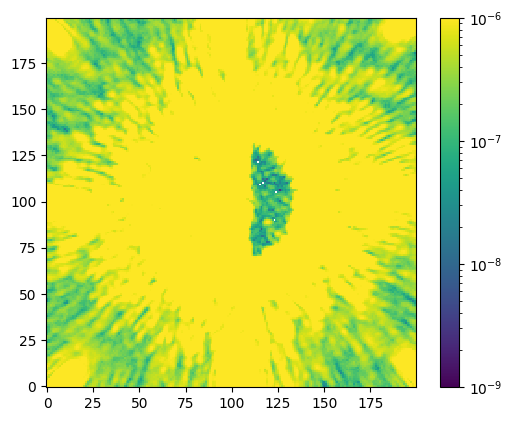

In [83]:
plt.imshow( (allseq_data[2]['dh_imlist'][-1]-allseq_data[2]['imbg']) / norm_cps, norm=LogNorm(vmin=1e-9, vmax=1e-6))
plt.colorbar()

In [297]:
#camstream.set_exposure_time(5, wait=5)

In [84]:
print('Setting camera')
#camstream.set_attenuation(0, wait=5)
#camstream.set_exposure_time(1, wait=5)

imdh = np.mean(camstream.grab_many(100),axis=0) #/ t1

print('Taking background')
imbg = take_bg(n=100, nwait=20)

Setting camera
Taking background


In [85]:
contrast_dh = np.mean((imdh-imbg)[dh_mask_proper])/ norm_cps
print(contrast_dh)
print(get_mean_contrast(imdh, imbg, dh_mask_proper, norm_cps))

1.9297102215413e-07
1.9297102215413e-07


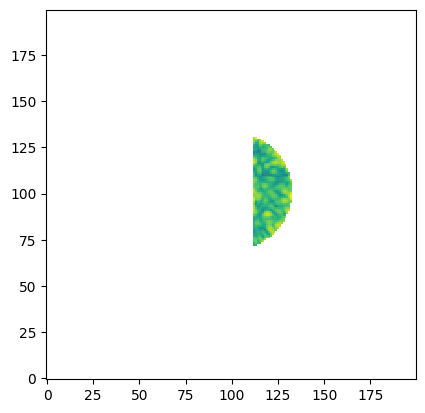

In [86]:
plt.imshow((imdh-imbg)/norm_cps*dh_mask_proper, norm=LogNorm(vmin=1e-9))

In [94]:
dh_ims = {
    'imdh' : imdh,
    'imbg' : imbg,
    'mask' : dh_mask
}

save_dict_to_h5(os.path.join(basedir, 'calib2_dh.h5'), dh_ims)

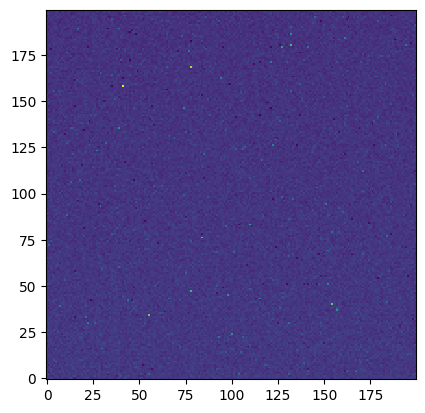

In [89]:
plt.imshow(imbg)

# Plotting

In [87]:
lambdaD_labels = [1,3,10]#[1,3,10]
im_dh = imdh
im_bg = imbg

print(np.mean( (im_dh - im_bg)[dh_mask]) / norm_cps)
print(np.median( (im_dh - im_bg)[dh_mask])  / norm_cps)
print(np.min( (im_dh - im_bg)[dh_mask])  / norm_cps)

2.8023486040612876e-07
1.543208505201063e-07
1.5363801489833592e-08


In [137]:
#dmch3.write(dh_cmd_good)

(<Figure size 600x500 with 2 Axes>,
 <Axes: xlabel='x ($\\lambda/D$)', ylabel='y ($\\lambda/D$)'>)

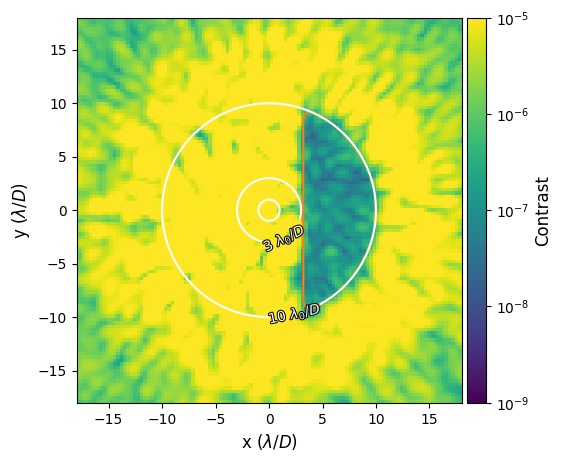

In [88]:
iefc.plot_dh((im_dh - im_bg), norm_cps, coreyx, plate_scale,
        dh_mask_proper, lambdaD_labels, vmin=1e-9, vmax=1e-5, xlim=18, ylim=18)

(<Figure size 600x500 with 2 Axes>,
 <Axes: xlabel='x ($\\lambda/D$)', ylabel='y ($\\lambda/D$)'>)

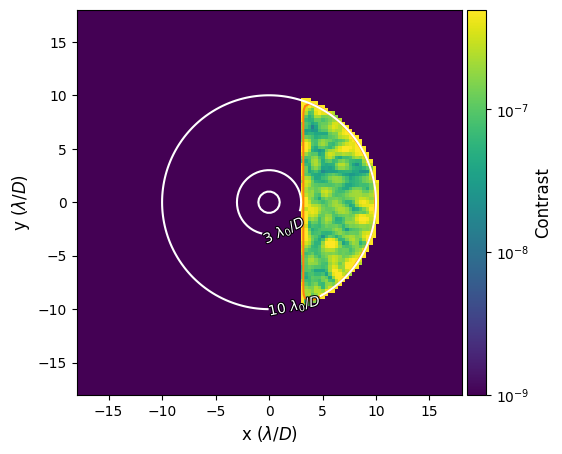

In [90]:
iefc.plot_dh(dh_mask * (im_dh - im_bg), norm_cps, coreyx, plate_scale,
        dh_mask_proper, lambdaD_labels, vmin=1e-9, vmax=5e-7, xlim=18, ylim=18)

Text(0, 0.5, 'Contrast')

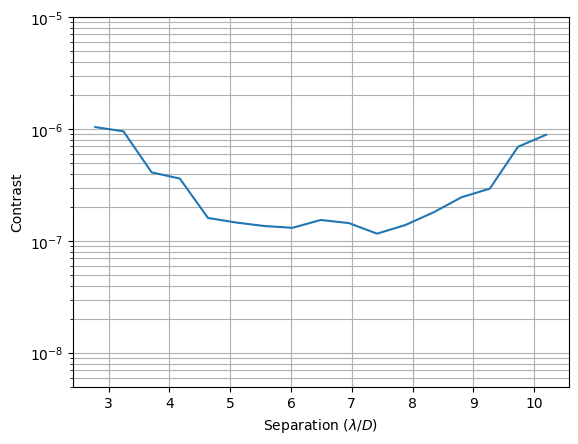

In [93]:
bins, profile_contrast = get_radial_contrast( (im_dh - im_bg) / norm_cps, mask_dh, nbins=100, cenyx=coreyx)
#profile_contrast = profile / speckle_t1 * contrast_speckle / tfactor
plt.semilogy(bins / plate_scale, profile_contrast)
plt.grid(which='both')
plt.ylim(5e-9, 1e-5)
plt.xlabel('Separation ($\lambda/D$)')
plt.ylabel('Contrast')

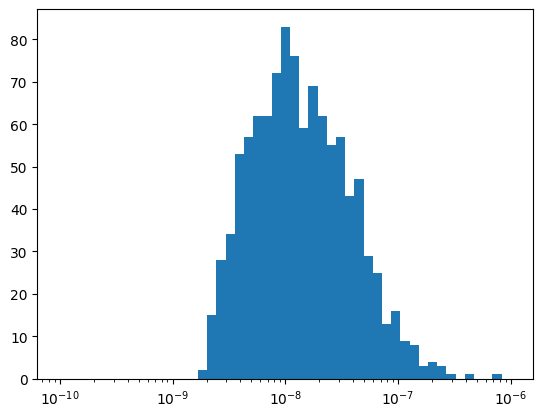

In [94]:
bins = 10**np.linspace(-10, -6, num=50)
hist = plt.hist((im_dh - im_bg)[dh_mask] / norm_cps, bins=bins)
plt.xscale('log')

wavelengths calcs

In [135]:
630*0.02

12.6

In [145]:
# 10% range is...
wmin = 630*(1-0.05)
wmax = 630*1.05

wrange = wmax-wmin

print(wmin, wmax, wrange)

w_2pcent = 630*0.02

598.5 661.5 63.0


In [144]:
nbands = 5
for n in range(nbands):
    print(wmin + w_2pcent*n, wmin + w_2pcent*(n+1))

598.5 611.1
611.1 623.7
623.7 636.3
636.3 648.9
648.9 661.5


measure contrast curves for current DH

# Other bandpasses

### narrow bands (DH images)


I'm assuming identical exposure times and camera settings for all these DHs...

In [464]:
print('Setting camera')
#camstream.set_attenuation(0, wait=1)
camstream.set_exposure_time(2, wait=5)

Setting camera


In [309]:
# get background
#imbg = take_bg(n=100, nwait=20)

In [145]:
# bands

In [310]:
#imdh_band1 = np.mean(camstream.grab_many(100),axis=0)

In [314]:
bg = np.mean(imdh_band1[:50,:])
np.mean((imdh_band1-bg)[dh_mask_proper])#/ norm_cps

31.40474895866426

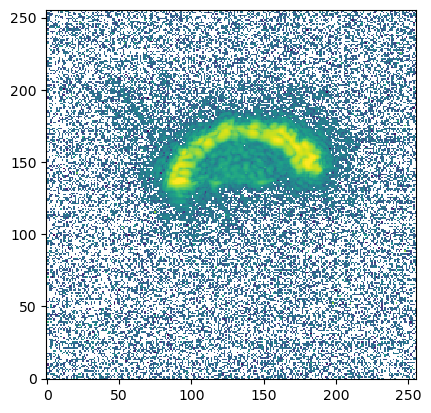

In [315]:
plt.imshow( (imdh_band1-bg), norm=LogNorm())

In [316]:
#imdh_band2 = np.mean(camstream.grab_many(100),axis=0)

In [317]:
bg = np.mean(imdh_band2[:50,:])
np.mean((imdh_band2-bg)[dh_mask_proper])#/ norm_cps

14.83449537454337

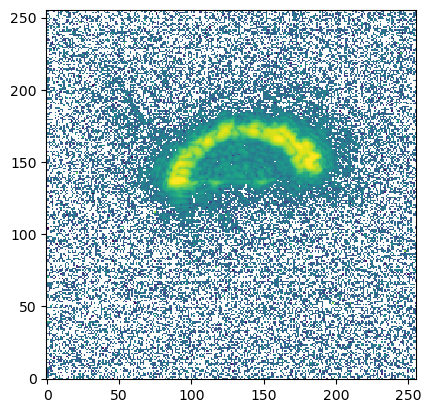

In [318]:
plt.imshow( (imdh_band2-bg), norm=LogNorm())

In [319]:
#imdh_band3 = np.mean(camstream.grab_many(100),axis=0) # 623.7 636.3

In [465]:
imdh_band3_2 = np.mean(camstream.grab_many(100),axis=0) # 623.7 636.3

8.159264634366032


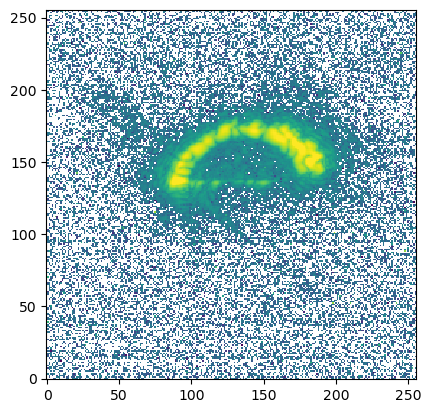

In [466]:
bg = np.mean(imdh_band3_2[:50,:])
print(np.mean((imdh_band3_2-bg)[dh_mask_proper]))
plt.imshow((imdh_band3_2-bg)/norm_cps, norm=LogNorm())

7.467073725684419


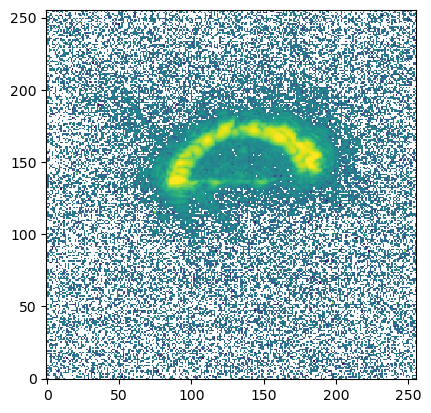

In [321]:
bg = np.mean(imdh_band3[:50,:])
print(np.mean((imdh_band3-bg)[dh_mask_proper]))
plt.imshow((imdh_band3-bg)/norm_cps, norm=LogNorm())

In [322]:
#imdh_band4 = np.mean(camstream.grab_many(100),axis=0) # 636.3 648.9

15.90230678021436


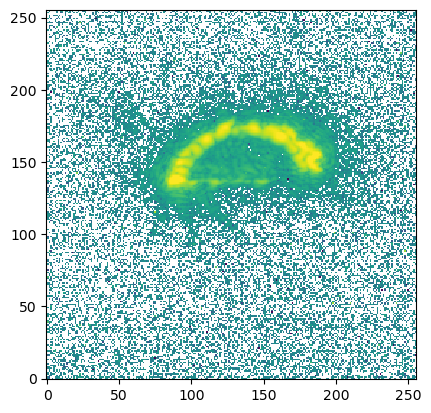

In [324]:
bg = np.mean(imdh_band4[:50,:])
print(np.mean((imdh_band4-bg)[dh_mask_proper]))
plt.imshow((imdh_band4-bg), norm=LogNorm())

In [325]:
#imdh_band5 = np.mean(camstream.grab_many(100),axis=0) # 648.9 661.5

48.3492168677954


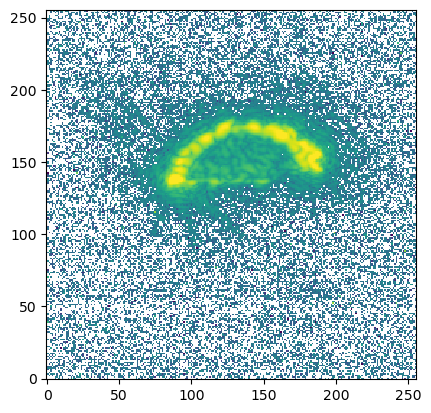

In [326]:
bg = np.mean(imdh_band5[:50,:])
print(np.mean((imdh_band5-bg)[dh_mask_proper]))
plt.imshow((imdh_band5-bg), norm=LogNorm())

In [1244]:
# broader bands centered at 630nm (DH images)

In [327]:
#imdh_5pcent = np.mean(camstream.grab_many(100),axis=0) # 614.25 645.75

In [468]:
#imdh_5pcent_2 = np.mean(camstream.grab_many(100),axis=0) # 614.25 645.75

In [328]:
#imdh_10pcent = np.mean(camstream.grab_many(100),axis=0) # 598.5 661.5

In [329]:
#imdh_15pcent = np.mean(camstream.grab_many(100),axis=0) # 582.75 677.25 

In [162]:
# common bg for all (???)
#imbg_post = take_bg(n=100, nwait=50)

In [330]:
# write out

dh_ims_band1 = {
    'imdh' : imdh_band1,
    'imbg' : imbg,
    #'imbg_post' : imbg_post,
    'mask' : dh_mask
}

save_dict_to_h5(os.path.join(basedir, 'calib2_dh_band1.h5'), dh_ims_band1)

In [331]:

dh_ims_band2 = {
    'imdh' : imdh_band2,
    'imbg' : imbg,
    #'imbg_post' : imbg_post,
    'mask' : dh_mask
}

save_dict_to_h5(os.path.join(basedir, 'calib2_dh_band2.h5'), dh_ims_band2)

In [332]:

dh_ims_band3 = {
    'imdh' : imdh_band3,
    'imbg' : imbg,
    #'imbg_post' : imbg_post,
    'mask' : dh_mask
}

save_dict_to_h5(os.path.join(basedir, 'calib2_dh_band3.h5'), dh_ims_band3)

In [467]:

dh_ims_band3 = {
    'imdh' : imdh_band3_2,
    'imbg' : imbg,
    #'imbg_post' : imbg_post,
    'mask' : dh_mask
}

save_dict_to_h5(os.path.join(basedir, 'calib2_dh_band3_2.h5'), dh_ims_band3)

In [333]:

dh_ims_band4 = {
    'imdh' : imdh_band4,
    'imbg' : imbg,
    #'imbg_post' : imbg_post,
    'mask' : dh_mask
}

save_dict_to_h5(os.path.join(basedir, 'calib2_dh_band4.h5'), dh_ims_band4)

In [334]:

dh_ims_band5 = {
    'imdh' : imdh_band5,
    'imbg' : imbg,
    #'imbg_post' : imbg_post,
    'mask' : dh_mask
}

save_dict_to_h5(os.path.join(basedir, 'calib2_dh_band5.h5'), dh_ims_band5)

In [335]:

dh_ims_5pcent = {
    'imdh' : imdh_5pcent,
    'imbg' : imbg,
    #'imbg_post' : imbg_post,
    'mask' : dh_mask
}

save_dict_to_h5(os.path.join(basedir, 'calib2_dh_5pcent.h5'), dh_ims_5pcent)

In [469]:

dh_ims_5pcent = {
    'imdh' : imdh_5pcent_2,
    'imbg' : imbg,
    #'imbg_post' : imbg_post,
    'mask' : dh_mask
}

save_dict_to_h5(os.path.join(basedir, 'calib2_dh_5pcent_2.h5'), dh_ims_5pcent)

In [336]:

dh_ims_10pcent = {
    'imdh' : imdh_10pcent,
    'imbg' : imbg,
    #'imbg_post' : imbg_post,
    'mask' : dh_mask
}

save_dict_to_h5(os.path.join(basedir, 'calib2_dh_10pcent.h5'), dh_ims_10pcent)

In [338]:
dh_ims_15pcent = {
    'imdh' : imdh_15pcent,
    'imbg' : imbg,
    #'imbg_post' : imbg_post,
    'mask' : dh_mask
}

save_dict_to_h5(os.path.join(basedir, 'calib2_dh_15pcent.h5'), dh_im6s_15pcent)

### calibration

In [472]:
# move field stop out
move_relative(client, 'stagepiezo.stagefold_pos', -50000) # + = in (left), - = out (right)

In [340]:
camstream.set_exposure_time(1e-3)

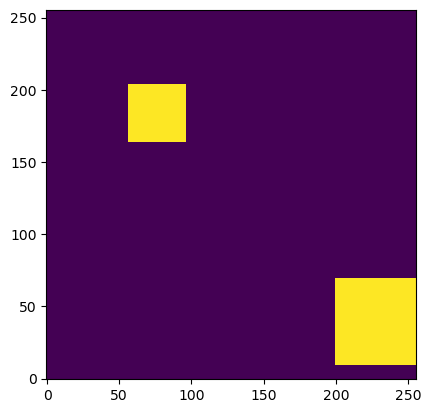

In [405]:
im_aligned = camstream.grab_latest()
shape = im_aligned.shape

mask = np.ones(shape, dtype=bool)
mask_speckle = np.zeros(shape, dtype=bool)
mask_speckle[184-20:184+20, 77-20:77+20] = 1
mask_core = np.zeros(shape, dtype=bool)
mask_core[30-20:30+40,220-20:220+40] = 1

calib_params = {
    'tilt_steps' : 60, # is this even used?
    'atten_max' : 0, #
    'atten_min' : 0,
    'gain_min' : 0,
    'gain_max' : 120,
    'cutout_extent_speckle' : 20,
    'cutout_extent_core' : 30,
    'mask_speckle' : mask_speckle,
    'mask_core' : mask_core,
    'plate_scale' : plate_scale,
    'exp_min' : 1e-4,
    'exp_max' : 10e-3,
    'exp_dh' : 10e-3
}

plt.imshow(mask_speckle + mask_core)

In [416]:
dmch3.write(dh_cmd_good)

In [470]:
move_relative(client, 'stagepiezo.stagepupil_x_pos', 200) # -34378L

In [471]:
move_relative(client, 'stagepiezo.stagepupil_y_pos', 200) # -34378L

In [343]:
camstream.set_gain(120)

In [344]:
camstream.set_exposure_time(10e-3)

In [487]:
# exp_min and gain_min should be set that off-axis core is not saturated but also such that
# at exp_max and gain_max you get high SNR on the speckle (without saturating once you max the source brightness)
camstream.set_gain(0, wait=2)
camstream.set_exposure_time(1e-4)

* √ band1
* √ band2
* √ band3
* √ band4
* √ band5
* √ 5%
* √ 10%
* 15%

In [488]:
def process_calibration_measurements(im_core, im_speckle, im_dh, calib_params, skip_conv=False):
    '''
    Use the measured attenuation in the reference speckle to determine the absolute counts per second in the core
    in the DH polarization state from the measured core in the calibration polarization state
    
    im_calibpol_tmax_gmax
    '''
    plate_scale = calib_params['plate_scale']
    
    # they're already in counts per sec
    core_calib_cps = im_core 
    speckle_calib_cps = im_speckle 
    speckle_dh_cps = im_dh
    
    # pick out the slices
    coreyx = get_core_centroid(im_core, calib_params['mask_core'])
    speckleyx = get_speckle_centroid(im_speckle, calib_params['mask_speckle'])
    
    extent_speckle = calib_params['cutout_extent_speckle']
    extent_core = calib_params['cutout_extent_core']
    speckle_slice = (slice(speckleyx[0]-extent_speckle//2, speckleyx[0]+extent_speckle//2),
                     slice(speckleyx[1]-extent_speckle//2, speckleyx[1]+extent_speckle//2))
    core_slice = (slice(coreyx[0]-extent_core//2, coreyx[0]+extent_core//2),
                  slice(coreyx[1]-extent_core//2, coreyx[1]+extent_core//2))
    print(speckle_slice, core_slice)
        
    # convolve with lambda/D gaussian(?) kernel
    apkernel = iefc.get_aperture_kernel(plate_scale, core_calib_cps.shape, oversample=16)
    
    if not skip_conv:
        core_calib_cps_apconv = imutils.convolve_fft(core_calib_cps, apkernel, force_real=True)
        speckle_calib_cps_apconv = imutils.convolve_fft(speckle_calib_cps, apkernel, force_real=True)
        speckle_dh_cps_apconv = imutils.convolve_fft(speckle_dh_cps, apkernel, force_real=True)
    else:
        core_calib_cps_apconv = core_calib_cps
        speckle_calib_cps_apconv = speckle_calib_cps
        speckle_dh_cps_apconv = speckle_dh_cps
    
    # compute the attenuation (due to gain, polarization, etc)
    atten = speckle_calib_cps_apconv[speckle_slice].max()  / speckle_dh_cps_apconv[speckle_slice].max()
    
    # compute the core CPS in the DH polarization
    core_cps_dh = core_calib_cps_apconv[core_slice].max() / atten
    
    # return all the things
    return {
        'core_slice' : core_slice,
        'speckle_slice' : speckle_slice,
        'core_calib_cps_apconv' : core_calib_cps_apconv,
        'speckle_calib_cps_apconv' : speckle_calib_cps_apconv,
        'speckle_dh_cps_apconv' : speckle_dh_cps_apconv,
        'atten' : atten,
        'core_cps_dh' : core_cps_dh,
        'coreyx' : coreyx,
        'speckleyx' : speckleyx
    }

Adjusting for non-saturated core
Taking measurements at settings for non-saturated core
Adjusting settings with known scaling for high SNR speckle measurement
Going to DH-digging settings (settings with unknown scaling) to get attenuation factor
Awaiting manual intervention (adjust to DH settings)
(slice(160, 180, None), slice(86, 106, None)) (slice(43, 73, None), slice(201, 231, None))
Attenuation factor: 0.2533248805493272
Core CPS: 1347801681.6177547
Speckle contrast: 0.00038153165040035814
Core contrast: 1.0
7.419489184786508e-10


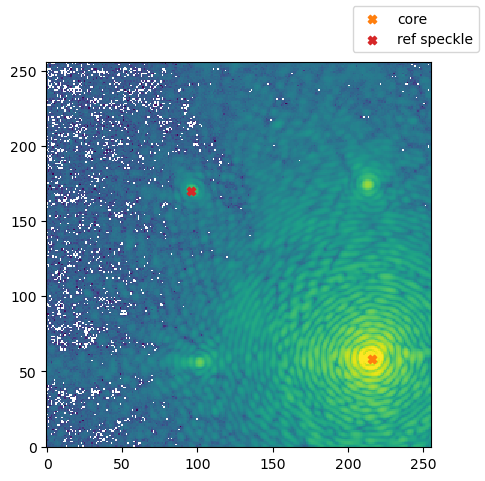

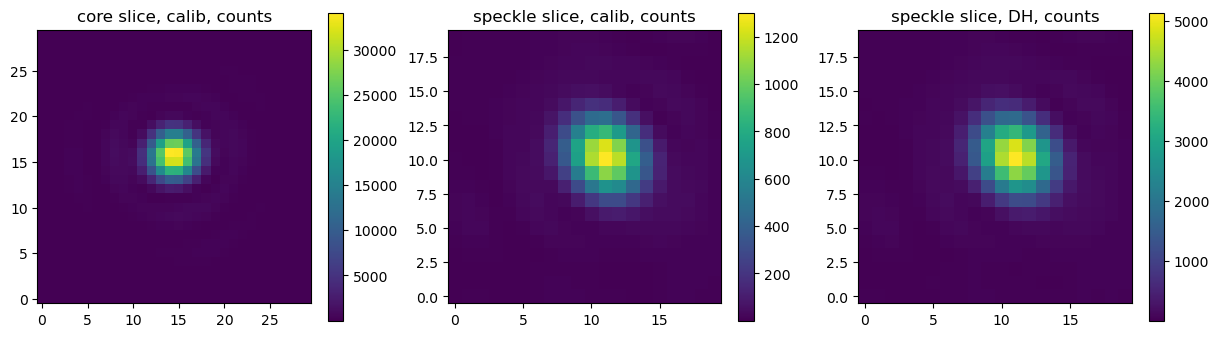

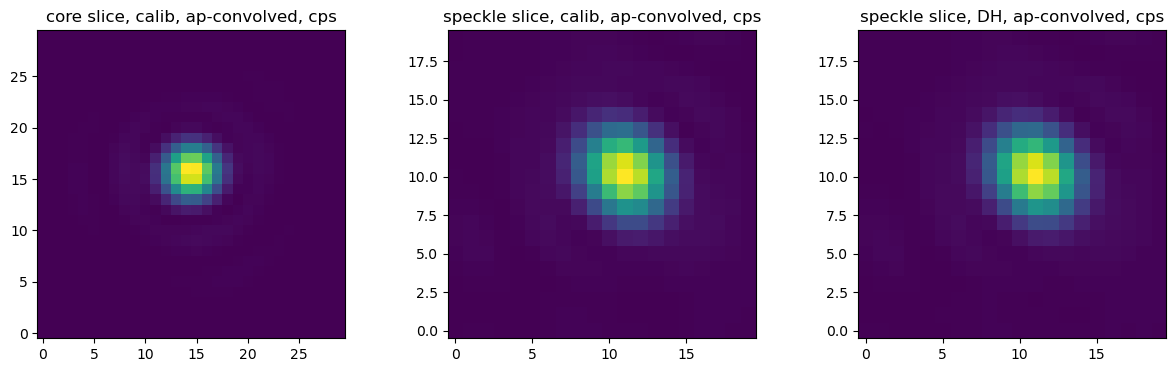

In [489]:
im_core, im_speckle, im_dh, im_core_bg, im_speckle_bg, im_dh_bg = autocalibrate_pre(im_aligned, camstream, client,
                                                                                   calib_params, satval=60000,
                                                                                    skip_fsm=True,
                                                                                   manual_intervention=True,
                                                                                   realign=False)

calib_proc = process_calibration_measurements(im_core-im_core_bg, im_speckle-im_speckle_bg, im_dh-im_dh_bg,
                                              calib_params, skip_conv=True)

display_calibration(calib_proc, im_core-im_core_bg, im_speckle-im_speckle_bg, im_dh-im_dh_bg)

norm_cps = calib_proc['core_cps_dh']
print(1/norm_cps)

6.053757571048982e-09


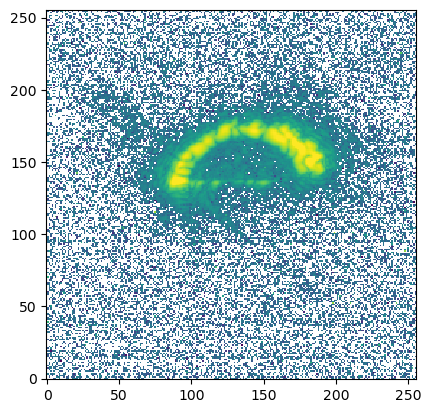

In [495]:
imdh_cur = imdh_band3_2#imdh_band3_2

bg = np.mean(imdh_cur[:50,:])
print(np.mean( (imdh_cur-bg)[dh_mask_proper])/norm_cps)
plt.imshow((imdh_cur-bg)/norm_cps, norm=LogNorm())

In [491]:
imutils.rms(dh_cmd, dm_mask) * 1e3

14.679827727377415

In [492]:
allcalib = {
    'calib_params' : calib_params,
    'calib_proc' : calib_proc,
    'im_core' : im_core,
    'im_speckle' : im_speckle,
    'im_dh' : im_dh,
    'im_core_bg' : im_core_bg,
    'im_speckle_bg' : im_speckle_bg,
    'im_dh_bg' : im_dh_bg,
}

save_dict_to_h5(os.path.join(basedir, 'allcalib_band3_2.h5'), allcalib)

In [493]:
ls iefc_2024_05_30_NKT_2pcent_andfriends_NSV571_BeamCoSubstrateVVC_aeroglazeLS_vacuum

allcalib_10pcent.h5   allcalib_band5.h5      calib2_dh_band2.h5
allcalib_15pcent.h5   allcalib.h5            calib2_dh_band3_2.h5
allcalib_5pcent_2.h5  calib1_dh.h5           calib2_dh_band3.h5
allcalib_5pcent.h5    calib1_seq.h5          calib2_dh_band4.h5
allcalib_band1.h5     calib2_dh_10pcent.h5   calib2_dh_band5.h5
allcalib_band2.h5     calib2_dh_15pcent.h5   calib2_dh.h5
allcalib_band3_2.h5   calib2_dh_5pcent_2.h5  calib2_seq2.h5
allcalib_band3.h5     calib2_dh_5pcent.h5    calib2_seq3_postbband.h5
allcalib_band4.h5     calib2_dh_band1.h5     calib2_seq.h5
